In [1]:
# Import library
import pandas  as pd #Data manipulation
import numpy as np #Data manipulation
import random as rnd
import matplotlib.pyplot as plt # Visualization
from matplotlib.ticker import StrMethodFormatter
from sklearn.preprocessing import LabelBinarizer #Data manipulation
from sklearn.preprocessing import MinMaxScaler #Data manipulation
from sklearn.model_selection import train_test_split #Data manipulation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


pd.options.display.max_rows = 1500
pd.options.display.max_columns = 999


Our data (.csv) is read in from the specified path and loaded into a pandas dataFrame.




Might be good to consider dropping useless columns from our data after the ttsplit.
If a col has enough data to pass our initial test it might get split unevenly and end up being under
the threshold for usefulness in either or train or test data...




In [2]:
path = "./housePriceData/"
df = pd.read_csv(path+'train.csv')

Firstly, lets check the data set for the presence of null values.

In [3]:
df.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

There are a significant number of null values present within several columns of the data set. This will have a detremental effect on our model so it is important that we deal with them accordingly.

Research carried out during the course of this project indiacted the prescene of "Abnormal" entries in the SaleCondition column. In the column description that accompanies the data set the "Abnormal" entry to the SaleCondition column is described as such:

"Abnorml:	Abnormal Sale -  trade, foreclosure, short sale" 

I deemed it appropriate to drop entries of this kind due to their nature.

In [4]:
df.dropna(1, thresh=((df.shape[0]) * 0.5), inplace=True)
df.dropna(0, thresh=(df.shape[1] * 0.5), inplace=True)
df.replace(np.nan,0, inplace = True)
df.dropna(subset = ["SalePrice"], inplace = True)
df.drop(['Id'], axis=1, inplace = True)
abnormalSales = df[df.SaleCondition == "Abnorml"]
df.drop(abnormalSales.index, inplace = True)

Any remaining null values are given a value of 0.

In [5]:
df.replace(np.nan,0, inplace = True)

A quick check to verify that we have removed all instances of null values throughout our data set.

In [6]:
df.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd

Any rows that do not have a sale price are dropped. ID is also dropped at this point as it does not influece the dependant variable (SalePrice) in any way.

SalePrice is the dependant variable in this data set, it plays an important so let's take a close look at it:

In [7]:
 def plotHist(df, column):
    
    ax = df.hist(column=column, bins=25, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

    ax = ax[0]
    for x in ax:

        # Despine
        x.spines['right'].set_visible(False)
        x.spines['top'].set_visible(False)
        x.spines['left'].set_visible(False)

        # Switch off ticks
        x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

        # Draw horizontal axis lines
        vals = x.get_yticks()
        for tick in vals:
            x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

        # Remove title
        x.set_title("")

        # Set x-axis label
        x.set_xlabel(column, labelpad=20, weight='bold', size=12)

        # Set y-axis label
        x.set_ylabel("Number of Entries", labelpad=20, weight='bold', size=12)

        # Format y-axis label
        x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

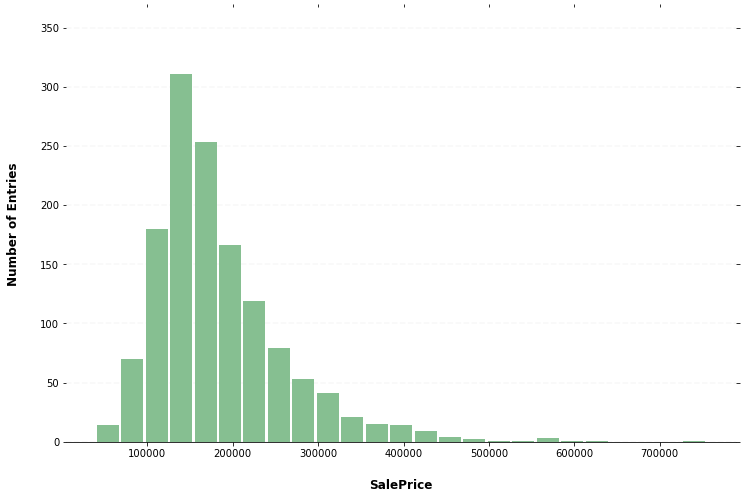

In [8]:
plotHist(df, 'SalePrice')

In [9]:
meanSalePrice = df.SalePrice.mean()
print("Mean SalePrice: {:.2f}".format (meanSalePrice))
salePriceStd = df.SalePrice.std()
print("Standard Deviation of SalePrice: {:.2f}".format (salePriceStd))

Mean SalePrice: 183477.38
Standard Deviation of SalePrice: 78620.42


You can see above that while the majority of house sales fall between 100,000 and 300,000 there are some outlying sales up around the 500,000+ range. This outlying data resides at the edges of the distribution and so is not reflective of the main body of the data.

With this in mind it is tempting to drop the rows contianing these outlying values and doing so could lead to in increase in statistical significance. However, they are natural members of the dataset and so must be included if the model is to be realistic in it's ambitions.

In [10]:
#outliersHigh = df[df.SalePrice > meanSalePrice+(3*salePriceStd)]
#df.drop(outliersHigh.index, inplace = True)

#outliersLow = df[df.SalePrice < 50000]
#df.drop(outliersLow.index, inplace = True)

#plotHist(df, 'SalePrice')

Data is split into two random subsets, corresponding to our training and validation data. 
"test_size=0.20" indicates that we utilize 20% of our data for testing, the remaining 80% to be used for training. 

In [11]:
rnd.seed()
(train, test) = train_test_split(df, test_size=0.20, random_state=rnd.randint(1, 100))

Scale dependant variable

In [12]:
maxSale = train["SalePrice"].max()
trainY = train["SalePrice"] / maxSale
testY = test["SalePrice"] / maxSale

TOdo: auto grab the below names and auto trim them to match the row cull

In [13]:
catCol = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
          'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
          'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
          'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond',
          'PavedDrive', 'SaleType', 'SaleCondition']

conCol  = ['MSSubClass','LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd','MasVnrArea', 'BsmtFinSF1',
           'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
           'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea',
           'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

In [14]:
lb = LabelBinarizer()

trainCat = np.array([]).reshape(len(train), 0)
testCat = np.array([]).reshape(len(test), 0)

for i in catCol:   
    #talk about asType(str) here
    lb.fit(df[i].astype(str))
    
    temp = lb.transform(train[i].astype(str))
    trainCat = np.hstack([trainCat, temp[:,1:]])
    
    temp = lb.transform(test[i].astype(str))
    testCat = np.hstack([testCat, temp[:,1:]])
    
print(trainCat.shape)
mms = MinMaxScaler()
#talk about fit_Transform vs transform
trainCon = mms.fit_transform(train[conCol])
testCon = mms.transform(test[conCol])

trainX = np.hstack([trainCat, trainCon])
testX = np.hstack([testCat, testCon])

(1087, 406)


The model is defined below. To begin a Sequential object is defined. Firstly the input layer is defined and then added, followed by the hidden layers.

The nodes in the input and hidden layers in the model have a rectified linear activation function applied to them. These nodes will either output the positive input the recieve or zero.

The ouput layer of the model is then added, it contains a single node and recieves linear activation.

The Adam optimiser is selected, Adam applies a type stochastic gradient descent in an attempt to minimise the loss function of the model. Adam is regarded as being lightweight so it is an appropriate choice for this project.

The model is compiled with a mean absolute percentage error loss function. I tried this with a mean squared error function but feel MAE worked better.

In [15]:
model = Sequential()

model.add(Dense(16, input_dim=trainX.shape[1], activation="relu"))

model.add(Dense(32, activation="relu"))
model.add(Dense(56, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation= "relu"))

model.add(Dense(1, activation="linear"))

opt = Adam(lr=1e-3, decay=1e-3 / 100)

model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

The model is trained in the below cell. After some experimentation I settled on an epoch count of 100 with a batch size of 16.
When using a higher epoch count I noticed my training and validation accuracies were diverging.

In [16]:
print("[INFO] training model...")
history = model.fit(x=trainX, 
                    y=trainY, 
                    validation_data=(testX, testY), 
                    epochs=100, 
                    batch_size=16, 
                    use_multiprocessing=True)


[INFO] training model...
Train on 1087 samples, validate on 272 samples
Epoch 1/100
1087/1087 [==============================] - 1s 504us/sample - loss: 25.4237 - val_loss: 23.6792
Epoch 2/100
1087/1087 [==============================] - 0s 97us/sample - loss: 17.7876 - val_loss: 19.9004
Epoch 3/100
1087/1087 [==============================] - 0s 97us/sample - loss: 15.6117 - val_loss: 17.6333
Epoch 4/100
1087/1087 [==============================] - 0s 96us/sample - loss: 13.7476 - val_loss: 17.2517
Epoch 5/100
1087/1087 [==============================] - 0s 97us/sample - loss: 12.0159 - val_loss: 15.0832
Epoch 6/100
1087/1087 [==============================] - 0s 97us/sample - loss: 10.8212 - val_loss: 16.5950
Epoch 7/100
1087/1087 [==============================] - 0s 99us/sample - loss: 9.6167 - val_loss: 14.4442
Epoch 8/100
1087/1087 [==============================] - 0s 95us/sample - loss: 8.9391 - val_loss: 14.0603
Epoch 9/100
1087/1087 [==============================] - 0s 95us/

1087/1087 [==============================] - 0s 96us/sample - loss: 2.8734 - val_loss: 11.2198
Epoch 77/100
1087/1087 [==============================] - 0s 96us/sample - loss: 2.8374 - val_loss: 11.4973
Epoch 78/100
1087/1087 [==============================] - 0s 97us/sample - loss: 2.9063 - val_loss: 10.9171
Epoch 79/100
1087/1087 [==============================] - 0s 94us/sample - loss: 2.9573 - val_loss: 12.5069
Epoch 80/100
1087/1087 [==============================] - 0s 96us/sample - loss: 3.0564 - val_loss: 11.2026
Epoch 81/100
1087/1087 [==============================] - 0s 96us/sample - loss: 2.7216 - val_loss: 11.2272
Epoch 82/100
1087/1087 [==============================] - 0s 96us/sample - loss: 2.6322 - val_loss: 11.3663
Epoch 83/100
1087/1087 [==============================] - 0s 95us/sample - loss: 2.7900 - val_loss: 11.0671
Epoch 84/100
1087/1087 [==============================] - 0s 96us/sample - loss: 2.7458 - val_loss: 11.2113
Epoch 85/100
1087/1087 [=================

Below, prediction data is extracted from the model. The normalised prediction values are returned to their original scale. The predictions and their accuracies are printed out and some relevant statistical variables are determined.

In [17]:
# make predictions using the testing data
predictions = model.predict(testX)
predictions = predictions.flatten()

#predictions are returned to the natural scale of prices by multiplying them by the max sale value that was used to scale the 
#train and test data.
predictionsDenormalised = predictions * maxSale

for (i, j) in zip(predictionsDenormalised, test["SalePrice"]):
    error = ( abs(i - j) / j ) * 100
    print( ("Prediction:{:7d}  -  Actual:{:7d}  -  Accuracy: {:.2f}%".format(int(i), j, (100 - error))))


#difference corresponds to the difference between the predictions and the test 'SalePrice' values.
difference = predictions - testY

percentDiff = (difference / testY) * 100
absPercentDiff = np.abs(percentDiff)
accuracies = 100 - absPercentDiff
averageAcc = np.mean(accuracies)
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)


Prediction: 177641  -  Actual: 175900  -  Accuracy: 99.01%
Prediction:  76219  -  Actual:  73000  -  Accuracy: 95.59%
Prediction: 170442  -  Actual: 167900  -  Accuracy: 98.49%
Prediction: 125009  -  Actual: 127000  -  Accuracy: 98.43%
Prediction:  93197  -  Actual:  81000  -  Accuracy: 84.94%
Prediction: 178609  -  Actual: 136500  -  Accuracy: 69.15%
Prediction: 117925  -  Actual: 135000  -  Accuracy: 87.35%
Prediction: 177216  -  Actual: 157500  -  Accuracy: 87.48%
Prediction: 124144  -  Actual: 130000  -  Accuracy: 95.50%
Prediction: 175489  -  Actual: 163900  -  Accuracy: 92.93%
Prediction: 116055  -  Actual: 100000  -  Accuracy: 83.94%
Prediction: 199040  -  Actual: 193000  -  Accuracy: 96.87%
Prediction: 145331  -  Actual: 129000  -  Accuracy: 87.34%
Prediction: 130453  -  Actual: 140000  -  Accuracy: 93.18%
Prediction: 149493  -  Actual: 148000  -  Accuracy: 98.99%
Prediction: 173975  -  Actual: 172500  -  Accuracy: 99.14%
Prediction: 196433  -  Actual: 215000  -  Accuracy: 91.3

In [18]:
print("Most accurate prediction: {:.2f}%".format(accuracies.max()))
print("Least accurate prediction: {:.2f}%".format(accuracies.min()))
print("Average accuracy: {:.2f}%".format(averageAcc))
print("Mean Error: {:.2f}%, std: {:.2f}%".format(mean, std))

Most accurate prediction: 100.00%
Least accurate prediction: 1.81%
Average accuracy: 89.16%
Mean Error: 10.84%, std: 13.00%


Mean absolute percentage error is plotted against epochs for both training and validation data.

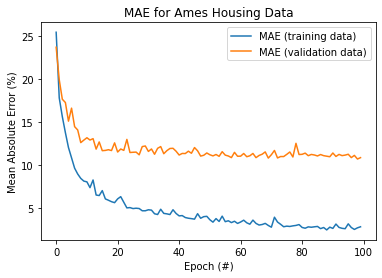

In [19]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for Ames Housing Data')
plt.ylabel('Mean Absolute Error (%)')
plt.xlabel('Epoch (#)')
plt.legend(loc="upper right")
plt.show()